#### **1. Introduction**
Focused on user_agents and noticed `axios/1.6.7`, which was clearly different from other user_agents like Mac, Windows, and etc.

Thus, SQL query `SELECT * FROM data WHERE user_agent LIKE '%axios%'` was used.

For this time, I wanted to use pandas instead of polars for practice purposes.

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_parquet('../data/logs.parquet')

In [3]:
# Filter the DataFrame for rows where 'user_agent' contains 'axios'
axios_data = df[df['user_agent'].str.contains('axios', na=False)]

# Display the filtered data
print(axios_data)
axios_data.to_csv('../data_preprocess/axios.csv')

               client_ip  user                time  \
34        129.213.34.158  None 2024-11-07 00:00:10   
35        129.213.34.158  None 2024-11-07 00:00:11   
42        129.213.34.158  None 2024-11-07 00:00:11   
142       129.213.34.158  None 2024-11-07 00:00:20   
188       129.213.34.158  None 2024-11-07 00:00:21   
...                  ...   ...                 ...   
10937531  129.213.34.158  None 2025-01-11 02:10:19   
10937532  129.213.34.158  None 2025-01-11 02:10:19   
10937884  129.213.34.158  None 2025-01-11 02:20:19   
10937885  129.213.34.158  None 2025-01-11 02:20:19   
10937886  129.213.34.158  None 2025-01-11 02:20:19   

                               request  http_status  request_body_bytes  \
34                 GET /stats HTTP/1.1          200                 183   
35        GET /stats/feedback HTTP/1.1          200                  25   
42                      GET / HTTP/1.1          200                   7   
142                     GET / HTTP/1.1          200

#### **2. Analysis on Time**
- Hourly Trends
    - Revealed noticeable spikes but lacked the detail needed to identify finer patterns.
- Minute Trends
    - Consistent pattern of 12 requests per minute for more than 100 minutes, indicating regular automated activity.
- Second Trends
    - Requests showed a consistent 5-second interval between requests, strongly suggesting bot-like behavior.

In [ ]:
# Convert 'time' column to datetime for time-based analysis
axios_data['time'] = pd.to_datetime(axios_data['time'])

# 1. Request Volume Over Time (Hourly)
request_volume = axios_data.groupby(df['time'].dt.floor('H')).size().reset_index(name='request_count')

# 2. Top Requested Resources
# Extracting endpoint from the 'request' column
axios_data['endpoint'] = axios_data['request'].str.split(' ').str[1]

# Counting frequency of each endpoint
top_requested_resources = axios_data['endpoint'].value_counts().reset_index()
top_requested_resources.columns = ['endpoint', 'request_count']

# Select the top 10 most requested endpoints
top_requested_resources_top10 = top_requested_resources.head(10)

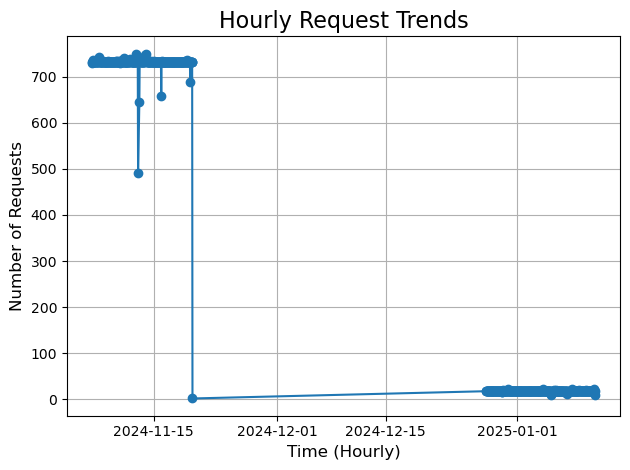

In [5]:
# Line plot for hourly request trends
plt.figure()
plt.plot(request_volume['time'], request_volume['request_count'], marker='o', linestyle='-')
plt.title('Hourly Request Trends', fontsize=16)
plt.xlabel('Time (Hourly)', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Filter for November requests
november_requests = axios_data[axios_data['time'].dt.month == 11]

# Total number of requests in November
total_november_requests = len(november_requests)
print(f"Total requests in November: {total_november_requests}")

Total requests in November: 225882


In [7]:
# Request Volume by Minute
request_volume_minute = axios_data.groupby(axios_data['time'].dt.floor('min')).size().reset_index(name='request_count')

# Request Volume by Second
request_volume_second = axios_data.groupby(axios_data['time'].dt.floor('s')).size().reset_index(name='request_count')

# Displaying the results for Request Volume by Minute and Second
request_volume_minute.head(100), request_volume_second.head(10)


(                  time  request_count
 0  2024-11-07 00:00:00             12
 1  2024-11-07 00:01:00             12
 2  2024-11-07 00:02:00             12
 3  2024-11-07 00:03:00             12
 4  2024-11-07 00:04:00             12
 ..                 ...            ...
 95 2024-11-07 01:35:00             12
 96 2024-11-07 01:36:00             12
 97 2024-11-07 01:37:00             12
 98 2024-11-07 01:38:00             12
 99 2024-11-07 01:39:00             12
 
 [100 rows x 2 columns],
                  time  request_count
 0 2024-11-07 00:00:10              1
 1 2024-11-07 00:00:11              2
 2 2024-11-07 00:00:20              1
 3 2024-11-07 00:00:21              1
 4 2024-11-07 00:00:26              1
 5 2024-11-07 00:00:31              1
 6 2024-11-07 00:00:36              1
 7 2024-11-07 00:00:41              1
 8 2024-11-07 00:00:46              1
 9 2024-11-07 00:00:51              1)

#### 3. Analysis on `request`
The most frequent time difference between consecutive requests was 5 seconds, occurring 199,966 times.

Minor deviations (e.g., 4 or 6 seconds) likely resulted from network latency or processing delays.

Requests primarily targeted specific endpoints like /stats and /stats/feedback.

In [8]:
# Grouping requests into 5-second intervals
axios_data['time_5sec'] = axios_data['time'].dt.floor('5s')
request_volume_5sec = axios_data.groupby('time_5sec').size().reset_index(name='request_count')

# Calculating time differences between consecutive requests
data_sorted = axios_data.sort_values(by='time')
time_diffs = data_sorted['time'].diff().dt.total_seconds()

# Frequency of specific time intervals (e.g., 5 seconds)
time_diff_frequency = time_diffs.value_counts().reset_index()
time_diff_frequency.columns = ['time_diff_seconds', 'frequency']

# Display the 5-second interval analysis and time difference frequencies
request_volume_5sec.head(10), time_diff_frequency.head(10)


/var/folders/q7/nwmjj1yn6_5gcy0r9yhcdjt40000gn/T/ipykernel_26257/2409790456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  axios_data['time_5sec'] = axios_data['time'].dt.floor('5s')


(            time_5sec  request_count
 0 2024-11-07 00:00:10              3
 1 2024-11-07 00:00:20              2
 2 2024-11-07 00:00:25              1
 3 2024-11-07 00:00:30              1
 4 2024-11-07 00:00:35              1
 5 2024-11-07 00:00:40              1
 6 2024-11-07 00:00:45              1
 7 2024-11-07 00:00:50              1
 8 2024-11-07 00:00:55              1
 9 2024-11-07 00:01:00              1,
    time_diff_seconds  frequency
 0                5.0     199966
 1                0.0       7370
 2                4.0       5000
 3                6.0       4065
 4                3.0       3091
 5                2.0       2346
 6                7.0       2237
 7                1.0       2201
 8                8.0       1509
 9                9.0       1033)

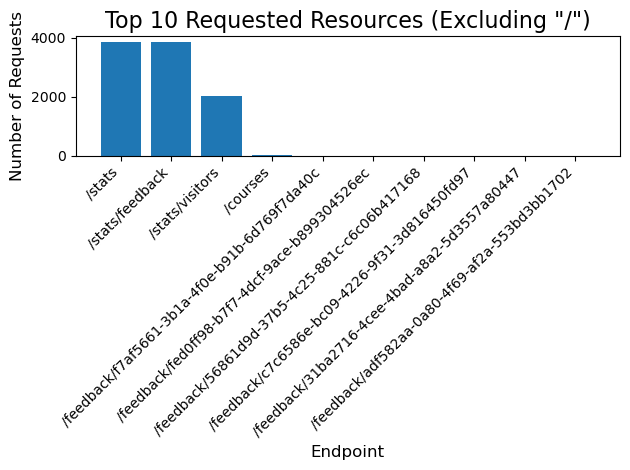

In [9]:

# Bar chart for top requested resources
# Filter out the root endpoint ('/') from the top requested resources
top_requested_resources_no_root = top_requested_resources[top_requested_resources['endpoint'] != '/'].head(10)

# Bar chart for top requested resources (excluding '/')
plt.figure()
plt.bar(top_requested_resources_no_root['endpoint'], top_requested_resources_no_root['request_count'])
plt.title('Top 10 Requested Resources (Excluding "/")', fontsize=16)
plt.xlabel('Endpoint', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
import numpy as np

# 1. Request Frequency Distribution: Analyze requests per second
# Calculate the time differences between consecutive requests
data_sorted = axios_data.sort_values(by='time')  # Ensure data is sorted by time
time_diffs = data_sorted['time'].diff().dt.total_seconds().dropna()  # Time differences in seconds

# Summary statistics of request intervals
time_diffs_summary = time_diffs.describe()

# 2. Analyze IP Address Dominance
ip_request_counts = axios_data['client_ip'].value_counts()

# 3. Analyze Endpoint Repetition for Top IPs
top_ip = ip_request_counts.idxmax()
top_ip_requests = axios_data[axios_data['client_ip'] == top_ip]['endpoint'].value_counts()

# Display results
analysis_results = {
    "Total Requests": ip_request_counts.max(),
    "TEndpoint Distribution": top_ip_requests.head(5),
}

analysis_results


{'Total Requests': 231914,
 'TEndpoint Distribution': endpoint
 /                                                 222043
 /stats                                              3861
 /stats/feedback                                     3859
 /stats/visitors                                     2012
 /feedback/f7af5661-3b1a-4f0e-b91b-6d769f7da40c         4
 Name: count, dtype: int64}

#### **5. Conclusion**
1. The consistent 5-second intervals
2. Specific endpoint targeting, and 
3. Over 200k requests in one month 

These provide strong evidence of bot-like activity. 

### Possible Solutions 
1. **Identify and Flag the IP:**
    - If confirmed as a bot, this IP should be flagged or blocked to prevent excessive load.
2. **Analyze Headers and Payloads:**
    - Check if the user_agent or request payloads provide further clues about automated behavior.